In [152]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import math
import random
import copy

In [150]:
base = "/Users/yashodeepmahapatra/Desktop/Text-Mining-1/bbcsport/"
os.chdir(base)
folders = os.listdir()
texts = []
for folder in folders:
    os.chdir(os.path.join(base, folder))
    files = os.listdir()
    for file in files:
        with open(file, 'rb') as curr_file:
            texts.append(str(curr_file.read()).lstrip("b\'").rstrip("b\'"))
# print(texts)
tfidf_vectorizer = TfidfVectorizer(texts, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(texts)
words = tfidf_vectorizer.get_feature_names()
vectors = tfidf.todense()
svd = TruncatedSVD(n_components = 3)
vectors_svd = svd.fit_transform(vectors)
vectors_svd = Normalizer().fit_transform(vectors_svd)
# print(vectors_svd.shape)
# fig=plt.figure()
# ax = Axes3D(fig)
# X = vectors_svd
# print(X)
# for j in range(len(X)):
#     ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
#     ax.view_init(330, 120)

/Users/yashodeepmahapatra/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [437]:
class PSO:
    def __init__(self, input_space, num_clusters = 5, n_components = 3, num_particles = 3, iterations = 100):
        assert(num_clusters>0)
        self.num_clusters = num_clusters
        self.n_components = n_components
        self.num_particles = num_particles
        self.input_space = input_space
        self.global_solution = np.full((num_clusters, n_components), 0)
        self.local_solution = np.full((num_particles, num_clusters, n_components), 0)
        self.global_best = math.inf
        self.local_best = np.full((num_particles), math.inf)
        self.iterations = iterations
        self.r1 = random.uniform(0, 1)
        self.r2 = random.uniform(0, 1)

    def distance(self, X1, X2, type = "euclidean"):
        assert(len(X1)==len(X2))
        assert(len(X1)==self.n_components)
        X1 = np.array(X1)
        X2 = np.array(X2)
        if(type=="euclidean"):
            return np.sqrt(np.sum(np.square(X1-X2)))
    
    def fitness(self, X, particle):
        assert(len(X)==self.num_clusters)
        assert(len(X[0][0])==self.n_components)
        assert(len(particle)==self.num_clusters)
        assert(len(particle[0])==self.n_components)
        X = np.array(X)
        particle = np.array(particle)
        Jc = 0
        for i in range(self.num_clusters):
            Jc += np.sum(np.sqrt(np.sum(np.square(particle[i] - X[i]), axis = 1)))
        return 1/(1+Jc)

    def pso_init(self):
        #velocity, position init
        Xs = []
        for i in range(self.num_particles):
            X = [[] for _ in range(self.num_clusters)]
            for j in range(len(self.input_space)):
                lottery = random.randint(0,self.num_clusters-1)
                X[lottery].append(self.input_space[j])
            Xs.append(X)
        for i in range(self.num_particles):
            for j in range(self.num_clusters):
                self.local_solution[i][j] = np.average(Xs[i][j], axis=0)
            self.local_best[i] = self.fitness(Xs[i], self.local_solution[i])
        index = -1
        for i in range(self.num_particles):
            if self.local_best[i]>self.global_best:
                self.global_best = self.local_best[i]
                index = i
        if index != -1:
            self.global_solution = copy.deepcopy(self.local_solution[i])

        self.component_limit_min = np.min(self.input_space, axis = 0)
        self.component_limit_max = np.max(self.input_space, axis = 0)
        self.velocity_limit_max = [0.001, 0.001, 0.001]#0.1 * (self.component_limit_max - self.component_limit_min)
        self.velocity_limit_min = [-0.001, -0.001, -0.001]#-0.1 * (self.component_limit_max - self.component_limit_min)

        self.velocity = []
        for i in range(self.num_particles):
            velocity = [[] for _ in range(self.num_clusters)]
            for j in range(self.num_clusters):
                for k in range(self.n_components): 
                    velocity[j].append(random.uniform(self.velocity_limit_min[k], self.velocity_limit_max[k]))
            self.velocity.append(velocity)
        self.velocity = np.array(self.velocity)
    
    def converge(self, w1 = 0.9, w2 = 0.4, c1 = 0, c2 = 2):
        self.w1 = w1
        self.w2 = w2
        self.c1 = c1
        self.c2 = c2
        self.pso_init()
        curr_position = copy.deepcopy(self.local_solution)
        curr_velocity = copy.deepcopy(self.velocity)
        for i in range(self.iterations):
            print("Iteration #"+str(i)+"....")
            w = (w1 - w2)*(self.iterations - i)/(self.iterations) + w2
            for j in range(self.num_particles):
                new_position = curr_position[j] + curr_velocity[j]
                new_velocity = w*curr_velocity[j] + self.c1*self.r1*(self.local_solution[j] - curr_position[j]) + self.c2*self.r2*(self.global_solution - curr_position[j])
                X = [[] for _ in range(self.num_clusters)]
                for k in range(len(self.input_space)):
                    distances = np.sum(np.square(new_position - self.input_space[k]),axis = 1)
                    X[np.argmin(distances)].append(self.input_space[k])
                for k in range(self.num_clusters):
                    if len(X[k])==0:
                        for l in range(self.num_clusters):
                            if len(X[l])>1:
                                pos = np.argmax(np.sum(np.square(X[l] - new_position[l]),axis = 1))
                                X[k].append(X[l][pos])
                                del(X[l][pos])
                                break
                for k in range(self.num_clusters):
                    curr_position[j][k] = np.average(X[k], axis = 0)
                curr_velocity[j] = copy.deepcopy(new_velocity)
                new_fitness = self.fitness(X, curr_position[j])
                print(new_fitness)
                if new_fitness > self.local_best[j]:
                    self.local_solution[j] = copy.deepcopy(new_position)
                    self.local_best[j] = new_fitness
            for j in range(self.num_particles):
                index = -1
                if self.local_best[j] > self.global_best:
                    self.global_best = self.local_best[j]
                    index = j
                if index != -1:
                    self.global_solution = copy.deepcopy(self.local_solution[index])
        X = [[] for _ in range(self.num_clusters)]
        for k in range(len(self.input_space)):
            distances = np.sum(np.square(self.global_solution - self.input_space[k]),axis = 1)
            X[np.argmin(distances)].append(self.input_space[k])
        print(len(X[0]))
        print(len(X[1]))
        print(len(X[2]))
        print(len(X[3]))
        print(len(X[4]))
        fig=plt.figure()
        ax = Axes3D(fig)
        colors=['r','m','y','k','c']
        for i in range(self.num_clusters):
            for j in range(len(X[i])):
                ax.scatter(X[i][j][0], X[i][j][1], X[i][j][2], color = colors[i], marker = 'o')





Iteration #0....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #1....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #2....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #3....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #4....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #5....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #6....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #7....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #8....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #9....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #10....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
Iteration #11....
0.0013550135501355014
0.0013550135501355014
0.0013550135501355014
It

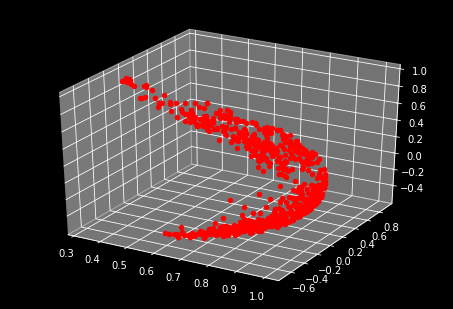

In [438]:
p1 = PSO(vectors_svd, iterations = 100)
p1.converge()